In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ML functions and plotting libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import scikeras
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import joblib

import keras
from keras.models import Sequential
from keras.layers import Dense #fully connected NN
from keras.optimizers import RMSprop

In [31]:
# file naming variables
latest_version = 'df_2023-06-13'
location = '/Users/Sim/Documents/Other/Programming/Personal Projects/property_valuation'

### 1. Loading the latest data

In [32]:
df=pd.read_csv(f'{location}/data/{latest_version}.csv')

In [33]:
df.tail(3)

,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,Portered,...,Outcode,Outcode2,Outcode3,Postcode,Centrality,North,Links,Date_Scraped,Month_Year,Avg_price
6753,20230612.0,790000.0,Warwick Avenue Station,0.3,Flat,2.0,1.0,989.0,1.0,1.0,...,W9,W9,W91,W91SQ,4.192989,1.0,https://www.rightmove.co.uk/properties/1360080...,2023-06-13,202306,173.0
6754,20230607.0,499950.0,St. John's Wood Station,0.3,Flat,1.0,1.0,470.0,1.0,1.0,...,NW8,NW8,NW89,NW89EJ,4.178467,1.0,https://www.rightmove.co.uk/properties/1358162...,2023-06-13,202306,261.0
6755,20230612.0,650000.0,Kilburn High Road Station,0.1,Flat,2.0,1.0,NaN,0.0,0.0,...,NW6,NW6,NW64,NW64LL,5.755045,1.0,https://www.rightmove.co.uk/properties/1360368...,2023-06-13,202306,102.0


In [34]:
df.head(3)

,Date,Price,NearStat,StatDist(miles),Prop_Type,Bedrooms,Bathrooms,Floor_Size,Outdoor,Portered,...,Outcode,Outcode2,Outcode3,Postcode,Centrality,North,Links,Date_Scraped,Month_Year,Avg_price
0,20211111.0,600000.0,Barbican Station,0.4,Apartment,1.0,1.0,NaN,0.0,0.0,...,EC1V,EC1,EC1V3,EC1V3NY,2.845931,1.0,NaN,2022-09-02,202209,110.0
1,20220826.0,450000.0,Angel Station,0.2,Apartment,1.0,1.0,NaN,0.0,0.0,...,EC1V,EC1,EC1V4,EC1V4LB,2.880314,1.0,NaN,2022-09-02,202209,151.5
2,20220318.0,600000.0,Battersea Power Underground Station,0.2,Flat,1.0,1.0,NaN,1.0,0.0,...,SW11,SW11,SW118,SW118EB,2.987774,0.0,NaN,2022-09-02,202209,160.0


In [35]:
#df['Month_Year'] = df['Date_Scraped'].astype('str').str[0:4] + df['Date_Scraped'].astype('str').str[5:7]
#df['Month_Year'] = df['Month_Year'].astype('int')

df.groupby('Month_Year').agg({'Month_Year': 'count'})

,Month_Year
Month_Year,
202209,1879
202210,499
202211,576
202301,776
202302,728
202303,695
202304,440
202305,757
202306,406


### 2. Data pre-processing & feature engineering

In [36]:
# Getting dummies vars
df2 = pd.concat([df, pd.get_dummies(df.iloc[:,2])], axis=1) #nearest station
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,4])], axis=1) #prop_type
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,10])], axis=1) #contract
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,12])], axis=1) #outcode2
df2 = pd.concat([df2, pd.get_dummies(df.iloc[:,19])], axis=1) #scraped_date

In [37]:
# Leave out 'Studio', 'Freehold', stations, a bunch of postcodes

variables = ['Price','StatDist(miles)','Bedrooms','Bathrooms','Outdoor','Portered','Apartment','Flat','House',
             'Maisonette','Mews', 'Terraced','Leasehold','NW6','SW1','N1','W2','W9','SE1','N7','NW1','EC1','NW3',
             'SW11','WC1','W1','NW8','W10','SW3','NW5','W11','SE11','North','Centrality','Floor_Size'] 

variables = variables + [202210, 202211, 202301, 202302, 202303, 202304] # Leaves out first month_year (202209)
variables = variables + ['Avg_price']

stations = ['Edgware Road (Circle, District, Hammersmith & City) Station',
            'St. John\'s Wood Station','Marylebone Station','Paddington Station',                                             
            'Edgware Road (Bakerloo) Station', 'Warwick Avenue Station','Lancaster Gate Station',
            'Marble Arch Station','Maida Vale Station',
            'Baker Street Station','Royal Oak Station']

df_varselect = df2[variables].dropna()
#df_varselect2 =df2[stations]
#df_varselect2 = pd.concat([df_varselect, df_varselect2], axis=1).dropna()
#df_varselect2
df_varselect['Avg_price2'] = df_varselect['Avg_price'] **2
df_varselect['Centrality2'] = df_varselect['Centrality'] **2
df_varselect['Floor_Size2'] = df_varselect['Floor_Size'] **2

In [38]:
df_varselect.columns

Index([          'Price', 'StatDist(miles)',        'Bedrooms',
             'Bathrooms',         'Outdoor',        'Portered',
             'Apartment',            'Flat',           'House',
            'Maisonette',            'Mews',        'Terraced',
             'Leasehold',             'NW6',             'SW1',
                    'N1',              'W2',              'W9',
                   'SE1',              'N7',             'NW1',
                   'EC1',             'NW3',            'SW11',
                   'WC1',              'W1',             'NW8',
                   'W10',             'SW3',             'NW5',
                   'W11',            'SE11',           'North',
            'Centrality',      'Floor_Size',            202210,
                  202211,            202301,            202302,
                  202303,            202304,       'Avg_price',
            'Avg_price2',     'Centrality2',     'Floor_Size2'],
      dtype='object')

### 3. Shuffling, Splitting and Normalising

In [39]:
X = np.array(df_varselect.iloc[:,1:df_varselect.shape[1]])

In [40]:
# Create feature and target arrays
X = np.array(df_varselect.iloc[:,1:df_varselect.shape[1]])
y = np.array(df_varselect.iloc[:,0])

# Shuffling data (to ensure random order) and performing 0.5 : 0.25 : 0.25 train-validation-test set splits
X_train, X_non, y_train, y_non = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_non, y_non, test_size=0.5, shuffle=True, random_state=1)

# Combining train and val for cross validation approach
X_tv, y_tv = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)]), pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)])
y_tv_arr = np.array(y_tv)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(X_tv.shape)
print(y_tv_arr.shape)

(1206, 44)
(603, 44)
(603, 44)
(1206,)
(603,)
(603,)
(1809, 44)
(1809, 1)


In [41]:
# Normalising
scaler = preprocessing.StandardScaler().fit(X_train)
#scaler_new = preprocessing.StandardScaler().fit(X_tv)

# Apply the scaling object to both train/validation/test sets
X_train_new = scaler.transform(X_train)
X_val_new = scaler.transform(X_val)
X_test_new = scaler.transform(X_test)
X_tv_new = scaler.transform(X_tv)

In [42]:
scaler2 = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

y_train_n = scaler2.transform(y_train.reshape(-1, 1))
y_val_n = scaler2.transform(y_val.reshape(-1, 1))
y_test_n = scaler2.transform(y_test.reshape(-1, 1))
y_tv_arr_n = scaler2.transform(y_tv_arr.reshape(-1, 1))

### 4. Model Training

#### 4A. Lasso Model

In [43]:
train_acc_dict = {}
val_acc_dict = {}

for a in np.arange(1, 3001, 5):
    reg = Lasso(alpha=a, random_state=123)
    reg = reg.fit(X_train_new, y_train)
    
    train_acc, val_acc = reg.score(X_train_new, y_train), reg.score(X_val_new, y_val)
    train_acc_dict[a], val_acc_dict[a] = train_acc, val_acc
    
best_alpha = max(val_acc_dict, key=val_acc_dict.get)
best_acc = round(val_acc_dict[best_alpha], 3)
print('The maximum validation set accuracy - %s - occurs at alpha = %s' % (best_acc, best_alpha))

The maximum validation set accuracy - 0.22 - occurs at alpha = 626


Text(627, 0.23, '(alpha=626, accuracy=0.22)')

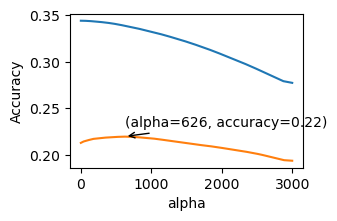

In [44]:
n_est = [x for x in np.arange(1, 3001, 5)]
train_acc = [acc for acc in train_acc_dict.values()]
val_acc = [acc for acc in val_acc_dict.values()]

# viz
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(n_est, train_acc)
ax.plot(n_est, val_acc)
fig.set_size_inches(3, 2)
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
ax.annotate('(alpha=%s, accuracy=%s)' % (best_alpha, best_acc), xy=(best_alpha, best_acc), xytext=(best_alpha + 1, best_acc+0.01), arrowprops=dict(arrowstyle="->", facecolor='black'))

In [45]:
# Using grid search and 10-fold CV instead

param_grid = {'alpha': np.arange(1, 2001, 5)}

grid_lr = GridSearchCV(Lasso(), param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_lr.fit(X_tv_new, y_tv_arr)
score_lr = grid_lr.best_score_
param_lr = grid_lr.best_params_
print('Best val accuracy - %s - occurs at alpha = %s' % (score_lr, param_lr['alpha']))
# 0.3615268259069946

# Saving the model
joblib.dump(grid_lr, 'models/grid_lr.sav')

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Best val accuracy - 0.2681706610153652 - occurs at alpha = 261


['models/grid_lr.sav']

In [46]:
# Saving the model
joblib.dump(grid_lr, 'models/grid_lr.sav')

['models/grid_lr.sav']

#### 4B. Random Forest Model
Next we train a random forest classifier. Using the loop in the code below, we train multiple RFs of varying n_estimators and choose the model that maximises validation set accuracy (i.e. minimises out of sample error).

In [47]:
# Using grid search and 10-fold CV instead

param_grid = {'max_depth': [5,10,15,20,25,30,35], 'n_estimators': [75,100,150,200,250,300,400]}

rf = RandomForestRegressor()

grid_rf = GridSearchCV(rf, param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_rf.fit(X_tv_new, y_tv_arr.ravel())
score_rf = grid_rf.best_score_
param_rf = grid_rf.best_params_
print('Best val accuracy - %s - occurs with parameters = %s' % (score_rf, param_rf))
# 0.4254 at 25, 150

# Saving the model
joblib.dump(grid_rf, 'models/grid_rf.sav')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best val accuracy - 0.4180943369510355 - occurs with parameters = {'max_depth': 25, 'n_estimators': 400}


['models/grid_rf.sav']

#### 4C. Gradient Boosting

In [48]:
param_test1 = {'n_estimators':range(350,851,25)}

gb = GradientBoostingRegressor(random_state = 123, learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt')

grid_gb1 = GridSearchCV(gb, param_grid = param_test1, verbose = 1,  cv = 10, scoring='r2')

grid_gb1.fit(X_tv_new, y_tv_arr.ravel())

print('Best val accuracy - %s - occurs with parameters = %s' % (grid_gb1.best_score_, grid_gb1.best_params_))
# 0.3941 at 725

Fitting 10 folds for each of 21 candidates, totalling 210 fits
Best val accuracy - 0.35213463073719786 - occurs with parameters = {'n_estimators': 575}


In [49]:
param_test2 = {'max_depth':range(5,23,2), 'min_samples_split':range(30,301,50)}

gb = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
                               learning_rate=0.1, min_samples_leaf=50, max_features='sqrt')

grid_gb2 = GridSearchCV(gb, param_grid = param_test2, verbose = 1,  cv = 10, scoring='r2')

grid_gb2.fit(X_tv_new, y_tv_arr.ravel())

print('Best val accuracy - %s - occurs with parameters = %s' % (grid_gb2.best_score_, grid_gb2.best_params_))
# 0.4148 at 11, 100

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best val accuracy - 0.3672439110128532 - occurs with parameters = {'max_depth': 19, 'min_samples_split': 30}


In [50]:
param_test3 = {'min_samples_leaf':range(10,61,10), 'max_features':range(2,8,1)}

gb = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
                               learning_rate=0.1, min_samples_split=grid_gb2.best_params_['min_samples_split'], 
                               max_depth=grid_gb2.best_params_['max_depth'])

grid_gb3 = GridSearchCV(gb, param_grid = param_test3, verbose = 1,  cv = 10, scoring='r2')

grid_gb3.fit(X_tv_new, y_tv_arr.ravel())

print('Best val accuracy - %s - occurs with parameters = %s' % (grid_gb3.best_score_, grid_gb3.best_params_))
# 0.4168 at 5, 30

#gb_final = GradientBoostingRegressor(random_state = 123, n_estimators=grid_gb1.best_params_['n_estimators'], 
#                                    learning_rate=0.1, min_samples_split=grid_gb2.best_params_['min_samples_split'], 
#                                    max_depth=grid_gb2.best_params_['max_depth'],
#                                    max_features = grid_gb3.best_params_['max_features'],
#                                    min_samples_leaf = grid_gb3.best_params_['min_samples_leaf'])

# Saving the model
joblib.dump(grid_gb3, 'models/grid_gb.sav')

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best val accuracy - 0.3802056947328816 - occurs with parameters = {'max_features': 7, 'min_samples_leaf': 10}


['models/grid_gb.sav']

In [51]:
# Saving the model
joblib.dump(grid_gb3, 'models/grid_gb.sav')

['models/grid_gb.sav']

#### 4D. KNN

In [52]:
# Using grid search and 10-fold CV instead

param_grid = {'n_neighbors': [i for i in range(1,60,1)]}

knn = KNeighborsRegressor()

grid_knn = GridSearchCV(knn, param_grid, verbose = 1,  cv = 10, scoring = 'r2')

# Fitting the grid model
grid_knn.fit(X_tv_new, y_tv_arr.ravel())
score_knn = grid_knn.best_score_
param_knn = grid_knn.best_params_
print('Best val accuracy - %s - occurs with parameters = %s' % (score_knn, param_knn))
# 0.1972 at 14

Fitting 10 folds for each of 59 candidates, totalling 590 fits
Best val accuracy - 0.15088469019783746 - occurs with parameters = {'n_neighbors': 14}


#### 4E. Neural Network
While neural networks are typically less effective on tabular data, I nonetheless build two (one smaller, one larger) to test their performance.

In [71]:
def larger_model():
    nn2 = Sequential()
    nn2.add(Dense(100, input_shape=(44,), kernel_initializer='normal', activation='relu'))
    nn2.add(keras.layers.Dropout(0.2))
    nn2.add(Dense(100, kernel_initializer='normal', activation='relu'))
    nn2.add(keras.layers.Dropout(0.2))
    nn2.add(Dense(100, kernel_initializer='normal', activation='relu'))
    nn2.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    nn2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return nn2

In [72]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_tv_new, y_tv_arr, cv=kfold, scoring='neg_mean_absolute_error')
print("Larger model avg -MAE: %.2f (%.2f)" % (results.mean(), results.std()))

Larger model avg -MAE: -74992.52 (3284.90)


### 5. Comparing tuned, best in class models

In [53]:
rf_grid = joblib.load('models/grid_rf.sav')
lr_grid = joblib.load('models/grid_lr.sav')
gb_grid = joblib.load('models/grid_gb.sav')

In [73]:
# NN test set error: larger model
larger_nn = estimators[0][1]
larger_nn.fit(X_tv_new, y_tv_arr.ravel(), verbose = False)  # was y_tv_arr.ravel
larger_nn.score(X_test_new, y_test)
# 0.21 orignially

0.08589037571119085

In [55]:
# Grid rand forest
#rf_grid = RandomForestRegressor(random_state=123, n_estimators=param_rf['n_estimators'] , 
#                                max_depth = param_rf['max_depth'] )
#rf_grid.fit(X_tv_new, y_tv_arr.ravel())

rf_grid.score(X_test_new,y_test)

0.49561923282565346

In [56]:
# Grid lasso
#lr_grid = Lasso(random_state=123, alpha = param_lr['alpha'])
lr_grid.score(X_test_new, y_test)

0.2811110105030391

In [57]:
# Grid grad boost
gb_grid.score(X_test_new,y_test)

0.5227075951952915

### 6. Extra digging into models/predictions

In [ ]:
y_pred = larger_nn.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Neural net has MAE = £%sk' % (int(str(round(mae))[:-3])))

In [22]:
y_pred = lr_grid.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Lasso has MAE = £%sk' % (int(str(round(mae))[:-3])))

Lasso has MAE = £73k


In [23]:
y_pred = gb_grid.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Gradient Boost has MAE = £%sk' % (int(str(round(mae))[:-3])))

Gradient Boost has MAE = £56k


In [24]:
y_pred = rf_grid.predict(X_test_new)
mae = mean_absolute_error(y_test, y_pred)
print('Grid Random Forest has MAE = £%sk' % (int(str(round(mae))[:-3])))

Grid Random Forest has MAE = £59k


### 7. Making Predictions

In [28]:
def value_prop(link, floor_size, month_year):
    area_df = pd.read_csv(f'{location}/data/area_df_2023.csv')
    
    # Create list of zeros to be populated with x variables
    x_vars = [0]*(len(df_varselect.columns)-1)
    link = [link]
    
    %run RightMove_Funcs.ipynb
    # use reformulated scraping code to scrape rightmove link to extract relevant variables into features list
    scraped2 = scrape_listings(date_from = 20220101, links=link)

    # Obtain variables
    prop_link, prop_features, prop_price = scraped2[1], scraped2[2],scraped2[3]
    prop_statname, statdist, outcode = scraped2[4], scraped2[5], scraped2[6]
    postcode, centrality, prop_date = scraped2[7],scraped2[8],scraped2[9]
    
    # Populating x_vars
    x_vars[0] = statdist[0] #StatDist(miles)

    if prop_features[0][1].startswith('×') and prop_features[0][2].startswith('×'): 
        x_vars[1] = int(prop_features[0][1][1]) #Bedrooms
        x_vars[2] = int(prop_features[0][2][1]) #Bathrooms
    elif prop_features[0][0].startswith('×') and prop_features[0][1].startswith('×'): 
        x_vars[1] = int(prop_features[0][0][1]) #Bedrooms
        x_vars[2] = int(prop_features[0][1][1]) #Bathrooms
    #x_vars[1] = int(prop_features[0][1][1]) 
    #x_vars[2] = int(prop_features[0][2][1]) 

    # Outdoor & Portered
    r= requests.get(link[0])
    soup = BeautifulSoup(r.text, 'lxml')

    porter_list = ['Porter','PORTER','porter', 'Concierge','CONCIERGE','concierge','Caretaker','caretaker','CARETAKER']
    outdoor_list = ['Balcony','BALCONY','balcony', 'Terrace','TERRACE','terrace', 'Patio', 'PATIO', 'patio', 'Garden', 'GARDEN', 'garden']

    lst = (soup.find_all("li", class_="lIhZ24u1NHMa5Y6gDH90A"))
    text =[str(x).replace('<li class="lIhZ24u1NHMa5Y6gDH90A">', '').replace('</li>', '') 
     for x in lst]
    for j in text:
        if any(k in j for k in outdoor_list):
            x_vars[3] = 1
        if any(k in j for k in porter_list):
            x_vars[4] = 1

    # Adding 1 to appropriate prop type dummy
    if prop_features[0][0] in variables:
        x_vars[variables.index(prop_features[0][0])-1] = 1

    # Contract var
    if prop_features[0][-1] == 'Leasehold':
        x_vars[11] = 1

    # Adding 1 to appropriate outcode dummy
    if outcode[0] in variables:
        x_vars[variables.index(str(outcode[0]))-1] = 1

    # North
    south = ['SE1','SE5','SE11','SE16','SE15','SE17','SW8','SW11','SW9','SW4','SW2']
    if outcode[0] not in south:
        x_vars[31] = 1

    # Centrality
    x_vars[32] = centrality[0]

    # Floor Size
    x_vars[33] = floor_size

    # Date
    if month_year in variables:
        x_vars[variables.index(month_year)-1] = 1

    # !!!!! x_vars[40] onwards -- increase each index (e.g. from 40 to 41) when get 202305 dummy variable in May!!!!!!!
    x_vars[40] = int(area_df.loc[area_df['Outcode3']==postcode[0][:-2], 'Avg_price'])
    # Squared terms
    x_vars[41], x_vars[42], x_vars[43] = x_vars[40]**2, centrality[0]**2, floor_size**2
    
    X = np.array(x_vars)
    print(np.around(scaler.transform(X.reshape(1, -1)),decimals=1))

    # run best models
    rf_pred = rf_grid.predict(scaler.transform(X.reshape(1, -1)))
    #non_grid_rf = best_rf.predict(scaler.transform(X.reshape(1, -1)))
    gb_pred = gb_grid.predict(scaler.transform(X.reshape(1, -1)))
    lr_pred = lr_grid.predict(scaler.transform(X.reshape(1, -1)))

    return(f'PREDICTIONS: 1. Gradient boost £{str(int(gb_pred))[:-3]}k; 2. Random forest £{str(int(rf_pred))[:-3]}k; 3. Lasso £{str(int(lr_pred))[:-3]}k')

In [ ]:
df_varselect.columns

In [29]:
# Randolph Gardens - 777
value_prop(floor_size = 773, month_year = 202305, link = 'https://www.rightmove.co.uk/properties/135916049#/?channel=RES_BUY')

# Came out as 676, 677 & 669

IndexError: list index out of range

In [108]:
# Highbury & Islington - 742, 765
value_prop(floor_size = 765, month_year = 202305, link = 'https://www.rightmove.co.uk/properties/135341420#/?channel=RES_BUY')

[[-0.3  0.7 -0.4 -1.  -0.6  1.4 -1.2 -0.  -0.2 -0.  -0.1  0.5 -0.3 -0.3
  -0.3 -0.3 -0.2 -0.3 -0.2 -0.3 -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4  0.7  0.7 -0.3 -0.3 -0.4 -0.4 -0.3 -0.3  0.1 -0.1
   0.6  0.5]]


'PREDICTIONS: 1. Gradient boost £650k; 2. Random forest £640k; 3. Lasso £650k'

In [109]:
# Carlton Vale - Hamptons. 869 or 908 sq ft (depednding on incl. 1st floor dead space)
# Try changing area code to W91 
# Add option to manually add garden (scraper often misses it)
value_prop(floor_size = 908, month_year = 202303, link = 'https://www.rightmove.co.uk/properties/85637178#/?channel=RES_BUY')

[[ 0.4  0.7 -0.4 -1.  -0.6 -0.7  0.8 -0.  -0.2 -0.  -0.1  0.5  3.3 -0.3
  -0.3 -0.3 -0.2 -0.3 -0.2 -0.3 -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4  0.9  1.4 -0.3 -0.3 -0.4 -0.4  2.9 -0.3 -1.  -0.6
   0.8  1.2]]


'PREDICTIONS: 1. Gradient boost £609k; 2. Random forest £645k; 3. Lasso £641k'

In [110]:
# Carleton Road
np.set_printoptions(suppress=True)
value_prop(floor_size = 804, month_year = 202303, link = 'https://www.rightmove.co.uk/properties/132042029#/?channel=RES_BUY')

[[ 1.1  0.7 -0.4  1.  -0.6  1.4 -1.2 -0.  -0.2 -0.  -0.1 -1.9 -0.3 -0.3
  -0.3 -0.3 -0.2 -0.3  5.5 -0.3 -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4  0.8  0.9 -0.3 -0.3 -0.4 -0.4  2.9 -0.3 -0.7 -0.5
   0.8  0.7]]


'PREDICTIONS: 1. Gradient boost £603k; 2. Random forest £620k; 3. Lasso £620k'

In [111]:
# Royal College Street - Legacy Properties
value_prop(floor_size = 864, month_year = 202304, link = 'https://www.rightmove.co.uk/properties/131986217#/?channel=RES_BUY')

[[-1.   2.1 -0.4  1.  -0.6  1.4 -1.2 -0.  -0.2 -0.  -0.1 -1.9 -0.3 -0.3
  -0.3 -0.3 -0.2 -0.3 -0.2  4.  -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4 -0.   1.2 -0.3 -0.3 -0.4 -0.4 -0.3  3.8 -0.9 -0.6
  -0.2  1. ]]


'PREDICTIONS: 1. Gradient boost £639k; 2. Random forest £645k; 3. Lasso £693k'

In [112]:
# Royal College Street Legacy - Olivers Town
value_prop(floor_size = 864, month_year = 202304, link = 'https://www.rightmove.co.uk/properties/126727847#/?channel=RES_BUY')

[[-1.   2.1 -0.4  1.  -0.6 -0.7  0.8 -0.  -0.2 -0.  -0.1  0.5 -0.3 -0.3
  -0.3 -0.3 -0.2 -0.3 -0.2  4.  -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4 -0.   1.2 -0.3 -0.3 -0.4 -0.4 -0.3  3.8 -0.9 -0.6
  -0.2  1. ]]


'PREDICTIONS: 1. Gradient boost £668k; 2. Random forest £622k; 3. Lasso £657k'

In [113]:
# Hillmartin Road
value_prop(floor_size = 725, month_year = 202301, link = 'https://www.rightmove.co.uk/properties/130506761#/?channel=RES_BUY')

[[-0.3  0.7 -0.4 -1.  -0.6 -0.7  0.8 -0.  -0.2 -0.  -0.1 -1.9 -0.3 -0.3
  -0.3 -0.3 -0.2 -0.3  5.5 -0.3 -0.2 -0.3 -0.2 -0.2 -0.2 -0.2 -0.1 -0.2
  -0.1 -0.1 -0.2  0.4  0.7  0.4 -0.3 -0.3  2.6 -0.4 -0.3 -0.3 -0.8 -0.5
   0.5  0.3]]


'PREDICTIONS: 1. Gradient boost £715k; 2. Random forest £633k; 3. Lasso £578k'

### 8. Working out what models do badly on

In [114]:
## Working out what model does badly on
# Join training_pred to y_tv and find sort by max diff. 
# For the samples with largest diff - join X_tv_new to find identifying column (centrality)
# Look at listing link and work out why model poorly valued it 
# Try to find new feature that might fix this
training_pred = pd.DataFrame(grid_rf.predict(X_tv_new)).reset_index(drop=True)
training_y = y_tv.reset_index(drop=True)
joint_df = pd.concat([training_pred, training_y], axis=1)
joint_df.columns = ['training_pred','actual_y']

joint_df['diff'] = np.round(joint_df['training_pred'] - joint_df['actual_y'],3)
joint_df
np.mean(abs(joint_df['diff']))

22954.384391929245

In [115]:
test_pred = pd.DataFrame(rf_grid.predict(X_test_new)).reset_index(drop=True)
test_y = pd.DataFrame(y_test).reset_index(drop=True)
joint_test_df = pd.concat([test_pred, test_y], axis=1)
joint_test_df.columns = ['test_pred','test_y']

joint_test_df['diff'] = np.round(abs(joint_test_df['test_pred'] - joint_test_df['test_y']),3)

joint_test_df['diff'].agg({'max diff': 'max', 'MAE': 'mean'})
#np.mean(abs(joint_test_df['diff']))
#max(abs(joint_test_df['diff']))

max diff    244560.248000
MAE          59916.464267
Name: diff, dtype: float64

In [116]:
test_centralities = pd.DataFrame(X_test)[32]
joint_test_df = pd.concat([joint_test_df, test_centralities], axis=1)
filtered_df = joint_test_df.loc[(joint_test_df['diff'] >= 100000)]
filtered_df

# NEXT: take centrality, use df_varselect to find listing. Look at link and explain valuation diff

,test_pred,test_y,diff,32
5,644222.000000,750000.0,105778.000,5.418778
7,586095.332000,700000.0,113904.668,2.425445
10,613804.262667,475000.0,138804.263,2.700246
12,569739.600000,450000.0,119739.600,5.979503
20,618507.481714,450000.0,168507.482,4.844890
...,...,...,...,...
595,627951.400000,460000.0,167951.400,4.806434
596,642135.000000,799950.0,157815.000,6.069394
597,637040.000000,750000.0,112960.000,5.382224
601,613345.800000,750000.0,136654.200,1.740493
